In [1]:
#installing some dependencies, CLIP was release in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"


#Your notebook process will restart after these installs

CUDA version: 12.2


In [2]:
roboflow_api_key = 'BPySdDc2dR80BGgpscEF'

In [3]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


In [4]:
# Install required packages
!pip install certifi
!pip install cycler
!pip install tensorflow-hub
!pip install torch
!pip install torchvision
!pip install ftfy
!pip install regex
!pip install roboflow
# !pip install torch==1.11.0 torchvision==0.12.0 ftfy regex

In [5]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import torch
from PIL import Image
import glob
from roboflow import Roboflow
import matplotlib.pyplot as plt

In [6]:
import roboflow

print(roboflow.__version__)

1.1.28


In [7]:
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace().project("hard-hat-sample-zilnr")
version = project.version(1)
dataset = version.download("clip")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Hard-Hat-Sample-1 in clip:: 100%|██████████| 124/124 [00:00<00:00, 2019.63it/s]


In [8]:
dataset.location

'/content/CLIP/Hard-Hat-Sample-1'

In [9]:

import os
#our the classes and images we want to test are stored in folders in the test set
class_names = os.listdir(dataset.location + '/test/')
class_names

['head_multiple helmet_multiple',
 'helmet',
 'head helmet_multiple',
 'helmet_multiple',
 '_tokenization.txt']

In [10]:

%cat {dataset.location}/test/_tokenization.txt

An example picture from the Hard Hat Sample dataset depicting a head, and helmets
An example picture from the Hard Hat Sample dataset depicting heads, and helmets
An example picture from the Hard Hat Sample dataset depicting a helmet
An example picture from the Hard Hat Sample dataset depicting helmets

In [11]:

#edit your prompts as you see fit here, be sure the classes are in teh same order as above
%%writefile {dataset.location}/test/_tokenization.txt

Overwriting /content/CLIP/Hard-Hat-Sample-1/test/_tokenization.txt


In [12]:

candidate_captions = []
with open(dataset.location + '/test/_tokenization.txt') as f:
    candidate_captions = f.read().splitlines()

## Run CLIP Inference on Dataset

In [13]:
import clip


def argmax(iterable):
    return max(enumerate(iterable), key=lambda x: x[1])[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)

correct = []

#define our target classificaitons, you can should experiment with these strings of text as you see fit, though, make sure they are in the same order as your class names above
text = clip.tokenize(candidate_captions).to(device)

for cls in class_names:
    class_correct = []
    test_imgs = glob.glob(dataset.location + '/test/' + cls + '/*.jpg')
    for img in test_imgs:
        #print(img)
        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

            pred = class_names[argmax(list(probs)[0])]
            #print(pred)
            if pred == cls:
                correct.append(1)
                class_correct.append(1)
            else:
                correct.append(0)
                class_correct.append(0)

    print('accuracy on class ' + cls + ' is :' + str(sum(class_correct)))
print('accuracy on all is : ' + str(sum(correct)))

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 157MiB/s]


accuracy on class head_multiple helmet_multiple is :1
accuracy on class helmet is :0
accuracy on class head helmet_multiple is :0
accuracy on class helmet_multiple is :0
accuracy on class _tokenization.txt is :0
accuracy on all is : 1


## Transfer learning with TensorFlow Hub

In [14]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard


In [15]:

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [16]:

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

61306/61306 [==============================] - 0s 0us/step


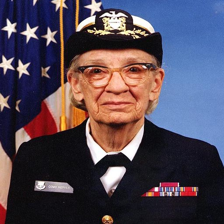

In [17]:

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [18]:

grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape


(224, 224, 3)

In [19]:

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 904ms/step


(1, 1001)

In [20]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

In [21]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


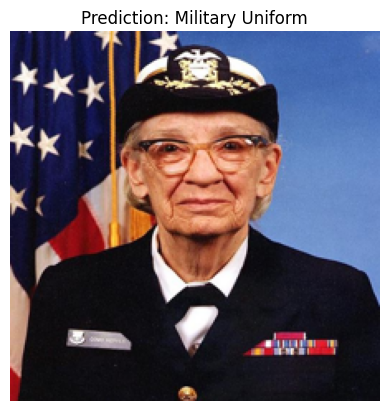

In [22]:

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

In [23]:
import pathlib

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

228813984/228813984 [==============================] - 4s 0us/step


In [24]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:

class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [26]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [27]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [29]:

result_batch = classifier.predict(train_ds)

92/92 [==============================] - 115s 1s/step


In [30]:

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names


array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

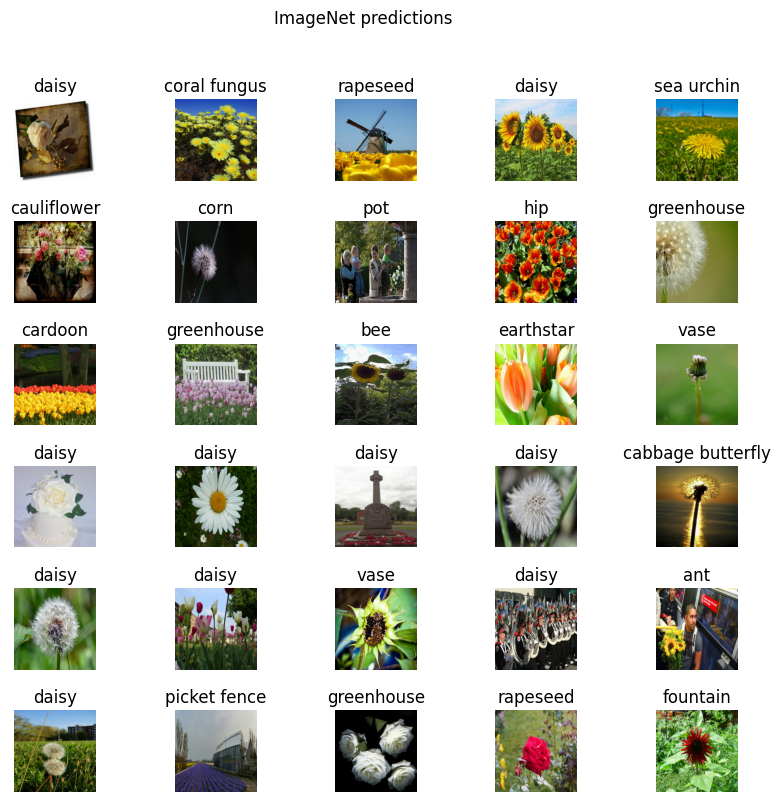

In [31]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [32]:

mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [33]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [34]:

feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [35]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [36]:

predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [37]:

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [38]:
NUM_EPOCHS = 3

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/3
92/92 [==============================] - 143s 2s/step - loss: 0.7562 - acc: 0.7292 - val_loss: 0.4214 - val_acc: 0.8719
Epoch 2/3
92/92 [==============================] - 123s 1s/step - loss: 0.3682 - acc: 0.8747 - val_loss: 0.3410 - val_acc: 0.8869
Epoch 3/3
92/92 [==============================] - 119s 1s/step - loss: 0.2895 - acc: 0.9050 - val_loss: 0.3110 - val_acc: 0.8951


In [39]:

predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 2s 2s/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'dandelion' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'dandelion' 'tulips' 'sunflowers']


## Visualizations

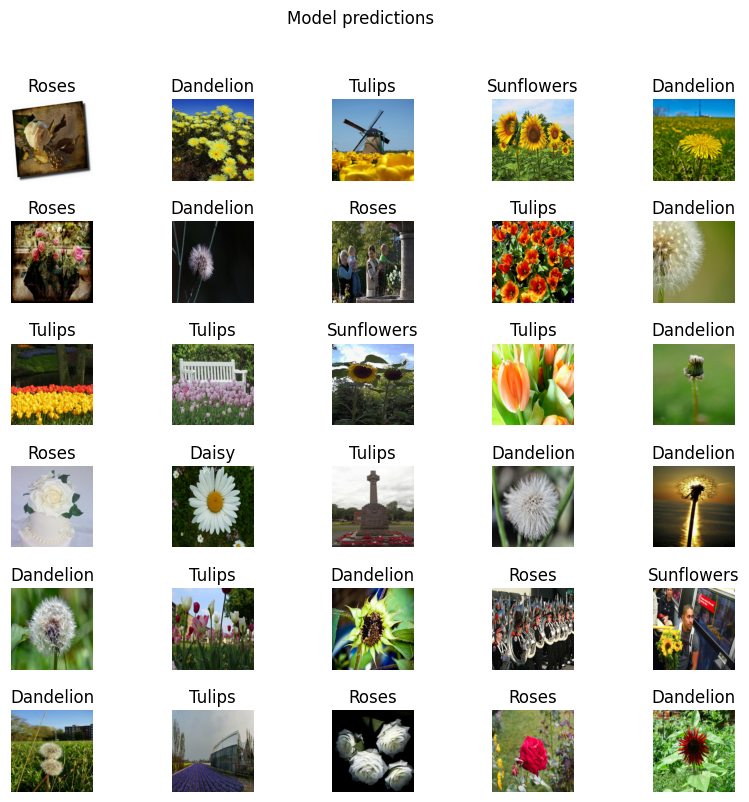

In [40]:

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


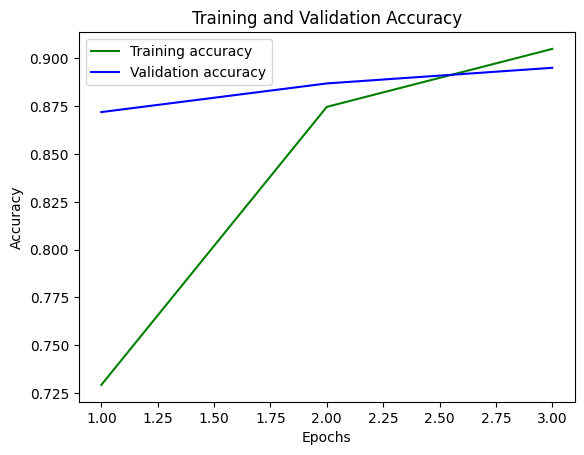

In [41]:

import matplotlib.pyplot as plt

# Get accuracy values from the history object
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot accuracy vs. epochs
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy', color='green')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
